In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

Using TensorFlow backend.


In [14]:
train_df = pd.read_csv('https://s3.amazonaws.com/ccwf-ml-data/jigsaw/train.csv')
test_df = pd.read_csv('https://s3.amazonaws.com/ccwf-ml-data/jigsaw/test.csv')

In [15]:
train_df['target'] = train_df['target'].apply(lambda x: 0 if x < 0.5 else 1)

In [22]:
FAST_TEXT = '/home/luis/ml-data/crawl-300d-2M.vec'
GLOVE = '/home/luis/ml-data/glove.840B.300d.txt'

In [23]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(FAST_TEXT, encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

1419it [00:00, 14185.82it/s]

loading word embeddings...


1999996it [01:47, 18687.06it/s]

found 1999996 word vectors


num train:  1804874
num test:  97320


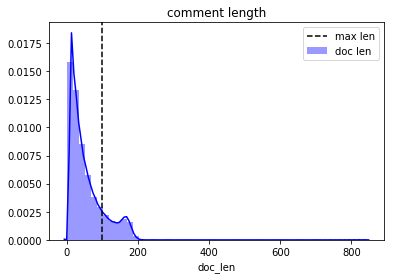

In [40]:
print("num train: ", train_df.shape[0])
print("num test: ", test_df.shape[0])

label_names = ["target"]
y_train = train_df[label_names].values

#visualize word distribution
train_df['doc_len'] = train_df['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [41]:
MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [42]:
raw_docs_train = train_df['comment_text'].tolist()
raw_docs_test = test_df['comment_text'].tolist() 
num_classes = 1 # positive or negative

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  1%|          | 12677/1804874 [00:00<00:29, 59810.44it/s]

pre-processing train data...


100%|██████████| 97320/97320 [00:01<00:00, 74885.93it/s]


tokenizing input data...
dictionary size:  318182


In [50]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [51]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 16603


In [52]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['permitslicensing' 'kyoki' 'ipetitions' 'intuitionally' 'cervelle'
 'baaaah' 'akfc' 'bimart' 'madinamerica' 'erazo']


In [53]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 99, 300)           30000000  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 99, 64)            134464    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 49, 64)            28736     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080

In [54]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [55]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

2019-05-05 19:49:25,533 From /home/luis/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
2019-05-05 19:49:25,623 From /home/luis/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1624386 samples, validate on 180488 samples
Epoch 1/8
 - 63s - loss: 0.1548 - acc: 0.9425 - val_loss: 0.1517 - val_acc: 0.9391
Epoch 2/8
 - 61s - loss: 0.1335 - acc: 0.9482 - val_loss: 0.1485 - val_acc: 0.9379
Epoch 3/8
 - 63s - loss: 0.1272 - acc: 0.9501 - val_loss: 0.1439 - val_acc: 0.9420
Epoch 4/8
 - 74s - loss: 0.1220 - acc: 0.9517 - val_loss: 0.1423 - val_acc: 0.9437
Epoch 5/8
 - 70s - loss: 0.1172 - acc: 0.9533 - val_lo

In [56]:
y_test = model.predict(word_seq_test)

In [57]:
#create a submission
submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_df['id'].values 
submission_df[label_names] = y_test 
submission_df.to_csv("./cnn_fasttext_submission.csv", index=False)

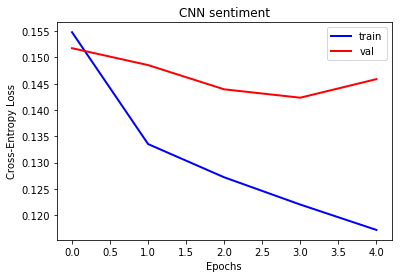

In [58]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

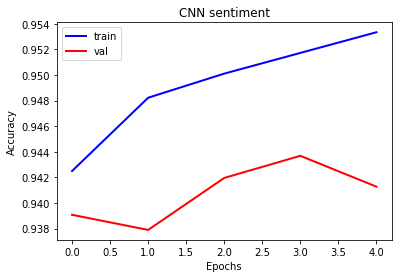

In [59]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()